In [1]:
import numpy as np
import simtk.unit as unit
import matplotlib.pyplot as plt
import openmolecularsystems as oms

# El doble pozo como modelo asociación-disociación

unión: acoplo, asociación...
desunión: desacoplo, ruptura, disociación...

Esta unidad requiere conocer: qué es la dinámica de langevin, qué es y cómo se usa openmm.

## El potencial de doble pozo asimétrico

Simulamos una partícula en un potencial de doble pozo asimétrico, en tres dimensiones, definido como:

\begin{equation}
V(x,y,z)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x + \frac{1}{2}k\left( y^2 + z^2 \right)
\end{equation}

Más información en: unidad de dinámica molecular, openmolecularsystems, etc.

Haremos uso de los parámetros para el potencial:

In [2]:
Eo = 3.0 * unit.kilocalories_per_mole
a = 0.5 * unit.nanometers
b = 0.5 * unit.kilocalories_per_mole
k = 1.0*unit.kilocalories_per_mole/unit.angstrom**2

Y para el sistema:

In [3]:
mass = 35.453 * unit.amu

In [4]:
osystem = oms.DoubleWell(mass=35.453*unit.amu, Eo=3.0*unit.kilocalories_per_mole,
                         a=5*unit.angstrom, b=0.5*unit.kilocalories_per_mole,
                         k=1.0*unit.kilocalories_per_mole/unit.angstrom**2)

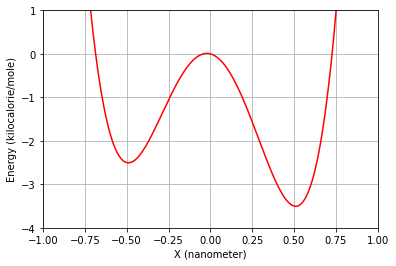

In [5]:
xyz_serie = np.zeros([200,3]) * unit.nanometers
xyz_serie[:,0] = np.linspace(-1.0, 1.0, num=200) * unit.nanometers

potential = osystem.evaluate_potential(xyz_serie)

plt.plot(xyz_serie[:,0], potential, 'r-')
plt.ylim(-4,1)
plt.xlim(-1,1)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.show()

In [6]:
initial_positions = np.zeros([1,3]) * unit.nanometers
initial_positions[0,0] = 0.51 * unit.nanometers

In [24]:
reporter = oms.tools.md.langevin_NVT(osystem, time=100*unit.nanoseconds,
                                     saving_timestep=10.0*unit.picoseconds,
                                     integration_timestep=0.1*unit.picoseconds,
                                     temperature=300.0*unit.kelvin,
                                     friction=1.0/unit.picoseconds,
                                     initial_coordinates=initial_positions,
                                     platform_name='CUDA')

1000000it [00:28, 34529.03it/s]        


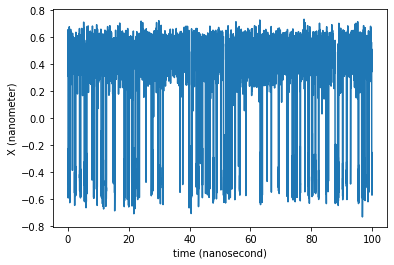

In [25]:
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), reporter['coordinates'][:,0,0])
plt.ylabel('X ({})'.format(reporter['coordinates'].unit))
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.show()

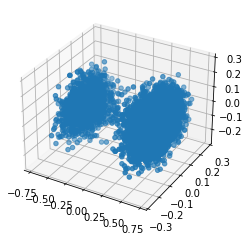

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(reporter['coordinates'][:,0,0], reporter['coordinates'][:,0,1],
           reporter['coordinates'][:,0,2])
ax.set_xlim3d([-0.8, 0.8])
ax.set_ylim3d([-0.3, 0.3])
plt.show()

In [28]:
def occupation_probability_density_1d(traj_x, x_range, n_bins):
    delta_x = (x_range[1]-x_range[0])/n_bins
    frequency = np.zeros(n_bins, dtype=int)
    for x in traj_x:
        bin_visited = int((x-x_range[0])/delta_x)
        frequency[bin_visited]+=1
    x_bins_centers = (x_range[0]+0.5*delta_x) + delta_x*np.arange(n_bins)
    bins_probability_density = (1.0/delta_x)*(frequency/frequency.sum())
    return x_bins_centers, bins_probability_density

In [16]:
traj_x = reporter['coordinates'][:,0,0]
x_center_bin, px = occupation_probability_density_1d(traj_x, [-1,1]*unit.nanometers, 50)

traj_y = reporter['coordinates'][:,0,1]
y_center_bin, py = occupation_probability_density_1d(traj_y, [-0.5,0.5]*unit.nanometers, 50)

traj_z = reporter['coordinates'][:,0,2]
z_center_bin, pz = occupation_probability_density_1d(traj_z, [-0.5,0.5]*unit.nanometers, 50)

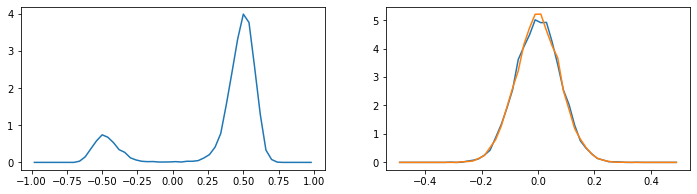

In [36]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches([12,3])
axs[0].plot(x_center_bin, px)
axs[1].plot(y_center_bin, py)
axs[1].plot(z_center_bin, pz)

plt.show()

Conocemos que podemos definir los estados asociado ("on" en ingles) y disociado ("off" en inglés) como las dos regiones del espacio conformacional separadas por el plano paralelo a $YZ$ ubicado en la coordenada $x_{b}$ en el eje $X$ correspondiente al máximo de la barrera del potencial.

In [44]:
xb = osystem.get_coordinates_maximum()[0][0]

Definiremos la constante de disociación como:

\begin{equation}
K_{D}=\frac{P_\textit{off}}{P_\textit{on}}
\end{equation}

Y la constante de asociación como:

\begin{equation}
K_{A}=\frac{P_\textit{on}}{P_\textit{off}}=\frac{1}{K_{D}}
\end{equation}

Donde $P_\textit{on}$ y $P_\textit{off}$ es la probabilidad de encontrar a la partícula en el pozo de la izquierda y en el de la derecha correspondientemente.

\begin{equation}
P_{on}=P(x\leq x_{b})
\end{equation}

\begin{equation}
P_{\textit{off}}=P(x>x_{b})
\end{equation}

De tal manera que por construcción:

\begin{equation}
1 = P_{\textit{off}}+P_{\textit{on}}
\end{equation}

Donde $x_b$ es la coordenada del máximo de la barrera.

Y estimaremos $K_{D}$ contando el número de eventos "on" ($m_\textit{on}$) y "off" ($m_\textit{off}$) observados a lo largo de nuestra partícula:

\begin{equation}
K_{D}=\frac{P_\textit{off}}{P_\textit{on}} \approx \frac{m_\textit{off}/M}{m_\textit{on}/M} =
\frac{m_\textit{off}}{m_\textit{on}}
\end{equation}

In [60]:
m_on = np.sum(traj_x<=xb)
m_off = traj_x.shape[0] - m_on
Kd = m_off/m_on

In [61]:
Kd

5.278091650973007

Decimos que $P_\textit{on}$ y $P_\textit{off}$, y por la tanto $K_\textit{D}$ y $K_\textit{A}$, nos describen la termodinámica del sistema. Pero no nos dicen nada de la cinética del proceso. Para ello debemos atender a las constantes cinéticas $K_\textit{on}$ y $K_\textit{off}$:

\begin{equation}
K_\textit{on} = P_{\textit{off}\rightarrow\textit{on}}
\end{equation}

\begin{equation}
K_\textit{off} = P_{\textit{on}\rightarrow\textit{off}}
\end{equation}


Donde $P_{\textit{off}\rightarrow\textit{on}}$ es la probabilidad de estando en el estado 'off', saltar al estado 'on', o escrito en términos de la probililidad condicionada:

\begin{equation}
P_{\textit{off}\rightarrow\textit{on}} = P(x>x_{b}| x\leq x_{b})
\end{equation}

Y $P_{\textit{on}\rightarrow\textit{off}}$ es la probabilidad de estando en el estado 'on', saltar al estado 'off':

\begin{equation}
P_{\textit{on}\rightarrow\textit{off}} = P(x\leq x_{b}| x>x_{b})
\end{equation}

Y podemos estimar estas probabilidades $P_{\textit{off}\rightarrow\textit{on}}$ y $P_{\textit{on}\rightarrow\textit{off}}$ contando en nuestra trayectoria el número de transiciones ${\textit{off}\rightarrow\textit{on}}$ ($m_{\textit{off}\rightarrow\textit{on}}$) y ${\textit{on}\rightarrow\textit{off}}$ ($m_{\textit{on}\rightarrow\textit{off}}$) observadas a lo largo de nuestra trayectoria:

\begin{equation}
K_\textit{on} = P_{\textit{off}\rightarrow\textit{on}} \approx \frac{m_{\textit{off}\rightarrow\textit{on}}}{m_\textit{off}}
\end{equation}

\begin{equation}
K_\textit{off} = P_{\textit{on}\rightarrow\textit{off}} \approx \frac{m_{\textit{on}\rightarrow\textit{off}}}{m_\textit{on}}
\end{equation}


In [62]:
m_off_to_on = 0
m_on_to_off = 0
traj_is_on = (traj_x<=xb)

for frame_index in range(traj_is_on.shape[0]-1):
    now = traj_is_on[frame_index]
    after = traj_is_on[frame_index+1]
    if now==True and after==False:
        m_on_to_off+=1
    elif now==False and after==True:
        m_off_to_on+=1

kon = m_off_to_on/m_off
koff = m_on_to_off/m_on

In [64]:
kon

0.010585156993339676

In [65]:
koff

0.05586942875078468

La primera pregunta que podemos hacernos es: ¿Cómo podemos estar seguros de que hemos obtenido una buena estimación del valor de $K_{d}$ para nuestro doble pozo?

In [ ]:
Veamos 

Ideas de las siguientes unidades:
    - Nuestras constantes cinéticas y termodinámicas nos dan un buen modelo?
    - Predicción de la termodinámica desde la mecánica estadística
    - Predicción de la cinética desde la teoría de procesos estocásticos
    
En las conclusiones finales poner preguntas como:
- Estará la termodinámica y cinética de un proceso de unión proteina-ligando bien descrito por un proceso de dos estados?